In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [2]:
folder = r"D:\Studium\DM-Dataset\physics.stackexchange.com\CSV"
file1 = "posts_to_users_with_lastdate.csv"
path1 = os.path.join(folder, file1)
df = pd.read_csv(path1)

In [3]:
df['CreationDate_user'] = pd.to_datetime(df['CreationDate_user'], errors='coerce')
df['LastActivityDate'] = pd.to_datetime(df['LastActivityDate'], errors='coerce')
# 计算真正活跃天数
df['RealActiveDays'] = (
    df['LastActivityDate'] - df['CreationDate_user']
).dt.days

# 去除负值或缺失值（可选）
df = df[
    df['RealActiveDays'].notna() & 
    (df['RealActiveDays'] >= 0)
]

count    555438.000000
mean        916.163799
std        1011.086916
min           0.000000
25%          75.000000
50%         548.000000
75%        1460.000000
90%        2464.000000
95%        3042.000000
99%        3954.000000
max        4900.000000
Name: RealActiveDays, dtype: float64


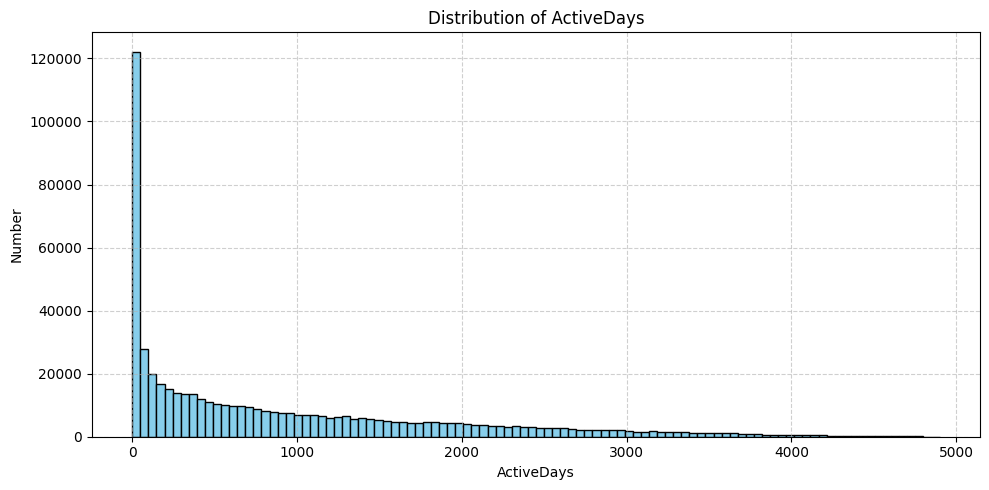

In [6]:
# 描述性统计（可选）
print(df['RealActiveDays'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

# 绘制直方图
plt.figure(figsize=(10, 5))
plt.hist(df['RealActiveDays'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of ActiveDays')
plt.xlabel('ActiveDays')
plt.ylabel('Number')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555438 entries, 0 to 782266
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Id_post                555438 non-null  float64       
 1   PostTypeId             555438 non-null  float64       
 2   AcceptedAnswerId       555438 non-null  float64       
 3   CreationDate_post      555438 non-null  object        
 4   Score                  555438 non-null  float64       
 5   ViewCount              555438 non-null  float64       
 6   Body                   555438 non-null  object        
 7   OwnerUserId            555438 non-null  float64       
 8   LastEditorUserId       276710 non-null  float64       
 9   LastEditDate           281289 non-null  object        
 10  LastActivityDate       555438 non-null  datetime64[ns]
 11  Title                  225001 non-null  object        
 12  Tags                   225001 non-null  object   

In [7]:
# 去掉 NaN 和负值（确保合法）
df_real = df[df['RealActiveDays'].notna() & (df['RealActiveDays'] >= 0)]

# 描述统计
print(df_real['RealActiveDays'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

count    555438.000000
mean        916.163799
std        1011.086916
min           0.000000
25%          75.000000
50%         548.000000
75%        1460.000000
90%        2464.000000
95%        3042.000000
99%        3954.000000
max        4900.000000
Name: RealActiveDays, dtype: float64


In [8]:
# 时间字段标准化
df['CreationDate_user'] = pd.to_datetime(df['CreationDate_user'], errors='coerce')
df['LastActivityDate'] = pd.to_datetime(df['LastActivityDate'], errors='coerce')
df['CreationDate_post'] = pd.to_datetime(df['CreationDate_post'], errors='coerce')

# 获取每个用户活跃的起止月份（以 Period[M] 表示）
df['StartMonth'] = df['CreationDate_user'].dt.to_period('M')
df['EndMonth'] = df['LastActivityDate'].dt.to_period('M')

In [9]:
def to_half_year(dt):
    return f"{dt.year}-H{1 if dt.month <= 6 else 2}"

# 1. 时间处理
df['CreationDate_post'] = pd.to_datetime(df['CreationDate_post'], errors='coerce')
df['CreationDate_user'] = pd.to_datetime(df['CreationDate_user'], errors='coerce')
df['HalfYear'] = df['CreationDate_post'].apply(to_half_year)

# 2. 基础聚合
half_df = df.groupby(['OwnerUserId', 'HalfYear']).agg({
    'Id_post': 'count',
    'Score': 'mean',
    'CommentCount': 'sum',
    'SentimentScore': 'mean',
    'PostTypeId': lambda x: (x == 1).mean(),
    'Reputation': 'max',
    'CreationDate_user': 'max'
}).reset_index()

# 3. 重命名
half_df.rename(columns={
    'Id_post': 'post_count',
    'Score': 'avg_score',
    'CommentCount': 'total_comments',
    'SentimentScore': 'avg_sentiment',
    'PostTypeId': 'question_ratio'
}, inplace=True)

# 4. 加入 HalfYear 排序键
half_df['HalfYearRank'] = pd.to_datetime(
    half_df['HalfYear'].str.replace('H1', '-01').str.replace('H2', '-07')
)

# 自定义函数：计算两个日期相差的月数
def months_between(later, earlier):
    if pd.isna(later) or pd.isna(earlier):
        return np.nan
    delta = relativedelta(later, earlier)
    return delta.years * 12 + delta.months

# 应用函数：计算注册到当前 HalfYear 的月数
half_df['account_age'] = half_df.apply(
    lambda row: months_between(row['HalfYearRank'], row['CreationDate_user']),
    axis=1
)

# 6. 排序
half_df = half_df.sort_values(['OwnerUserId', 'HalfYearRank'])

# 7. 构造滞后特征 + 差分特征
feature_base = ['post_count', 'avg_score', 'total_comments', 'avg_sentiment', 'question_ratio']
for feat in feature_base:
    half_df[f'{feat}_t-1'] = half_df.groupby('OwnerUserId')[feat].shift(1)
    half_df[f'{feat}_t-2'] = half_df.groupby('OwnerUserId')[feat].shift(2)
    half_df[f'delta_{feat}'] = half_df[f'{feat}_t-1'] - half_df[f'{feat}_t-2']

# 8. is_active / label
half_df['is_active'] = (half_df['post_count'] > 0).astype(int)
half_df['label'] = half_df.groupby('OwnerUserId')['is_active'].shift(-1).fillna(0).astype(int)

C:\Users\jiali\AppData\Local\Temp\ipykernel_21740\56970444.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  half_df['HalfYearRank'] = pd.to_datetime(


In [10]:
feature_cols = [
    'post_count_t-1', 'post_count_t-2', 'delta_post_count',
    'avg_score_t-1', 'avg_score_t-2', 'delta_avg_score',
    'total_comments_t-1', 'total_comments_t-2',
    'avg_sentiment_t-1', 'avg_sentiment_t-2', 'delta_avg_sentiment',
    'question_ratio_t-1', 'question_ratio_t-2',
    'Reputation',  'account_age'
]

In [28]:
model_df = half_df.dropna(subset=feature_cols + ['label'])

X = model_df[feature_cols].fillna(0)
y = model_df['label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

# 初始化基础模型
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 定义参数网格
param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8]
}

# 运行 Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 拟合
grid_search.fit(X_train, y_train)

# 输出最佳参数和模型
print("Best Parameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\jiali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:32:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}


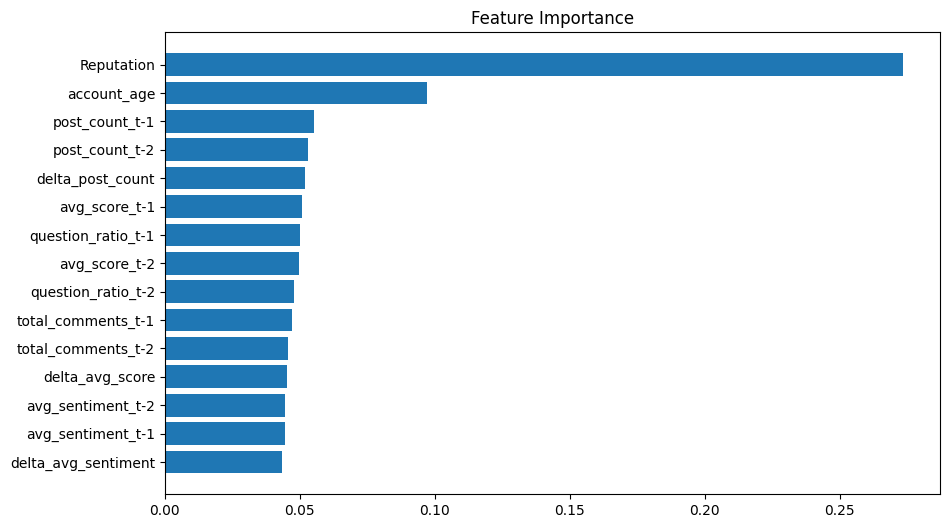

In [12]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh([feature_cols[i] for i in sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()

C:\Users\jiali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


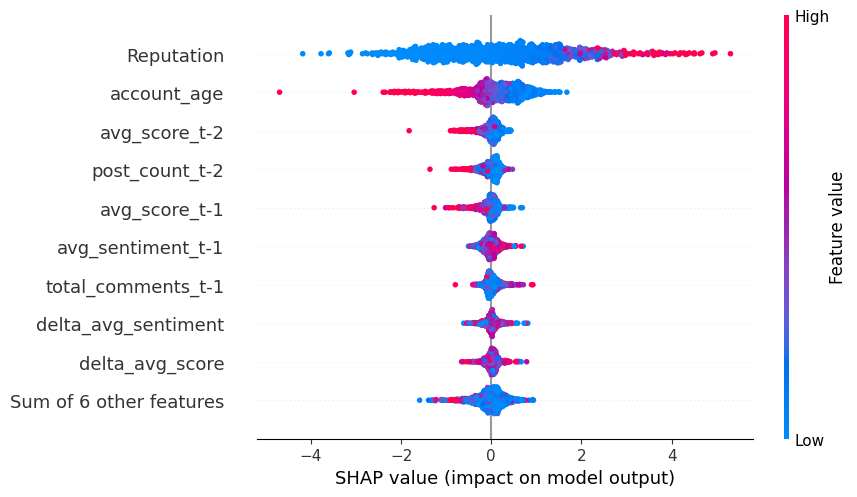

In [13]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test[:1000])

shap.plots.beeswarm(shap_values)

In [14]:
X_test['proba_1'] = y_proba  # 概率为活跃
X_test['pred_label'] = y_pred
X_test['true_label'] = y_test.values

# 找出真正 label=1 但被预测为 0 的高风险用户
false_negatives = X_test[(X_test['true_label'] == 1) & (X_test['pred_label'] == 0)]
high_risk_users = false_negatives.sort_values(by='proba_1')

# 可以导出用于召回或邮件通知

In [24]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 构造数据
model_df = half_df.dropna(subset=feature_cols + ['label'])
X = model_df[feature_cols]
y = model_df['label'].astype(int)

# 划分训练集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

# 建立模型
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.02,
    depth=6,
    eval_metric='AUC',
    verbose=100,
    random_state=42,
    early_stopping_rounds=50
)

# 训练
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# 评估
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("\n=== CatBoost 分类报告 ===")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

0:	test: 0.7484548	best: 0.7484548 (0)	total: 10.1ms	remaining: 10s
100:	test: 0.7827622	best: 0.7827622 (100)	total: 1.03s	remaining: 9.18s
200:	test: 0.7872018	best: 0.7872018 (200)	total: 2.08s	remaining: 8.29s
300:	test: 0.7900007	best: 0.7900007 (300)	total: 3.15s	remaining: 7.32s
400:	test: 0.7914292	best: 0.7914292 (400)	total: 4.13s	remaining: 6.17s
500:	test: 0.7927918	best: 0.7927918 (500)	total: 5.15s	remaining: 5.13s
600:	test: 0.7940564	best: 0.7940823 (584)	total: 6.14s	remaining: 4.08s
700:	test: 0.7948732	best: 0.7948732 (700)	total: 7.12s	remaining: 3.04s
800:	test: 0.7952577	best: 0.7952591 (799)	total: 8.11s	remaining: 2.02s
900:	test: 0.7955930	best: 0.7955930 (899)	total: 9.09s	remaining: 999ms
999:	test: 0.7958145	best: 0.7958197 (992)	total: 10.1s	remaining: 0us

bestTest = 0.7958196863
bestIteration = 992

Shrink model to first 993 iterations.

=== CatBoost 分类报告 ===
              precision    recall  f1-score   support

           0       0.63      0.46      0.5

In [27]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# 构造数据
model_df = half_df.dropna(subset=feature_cols + ['label'])
X = model_df[feature_cols]
y = model_df['label'].astype(int)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 初始化模型
cat_model = CatBoostClassifier(
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

# 设置超参数网格
param_grid = {
    'iterations': [1000],
    'learning_rate': [0.01, 0.02, 0.05],
    'depth': [4, 6, 8, 10]
}

# 运行 Grid Search
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best Parameters:", grid_search.best_params_)

# 最优模型
best_cat_model = grid_search.best_estimator_


Best Parameters: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.02}



=== Top 10 Important Features ===
               Feature  Importance
13          Reputation   34.864721
14         account_age   16.824522
3        avg_score_t-1    5.916362
4        avg_score_t-2    5.412120
0       post_count_t-1    4.715639
1       post_count_t-2    4.046299
2     delta_post_count    3.924289
8    avg_sentiment_t-1    3.558198
6   total_comments_t-1    3.471195
7   total_comments_t-2    3.434615


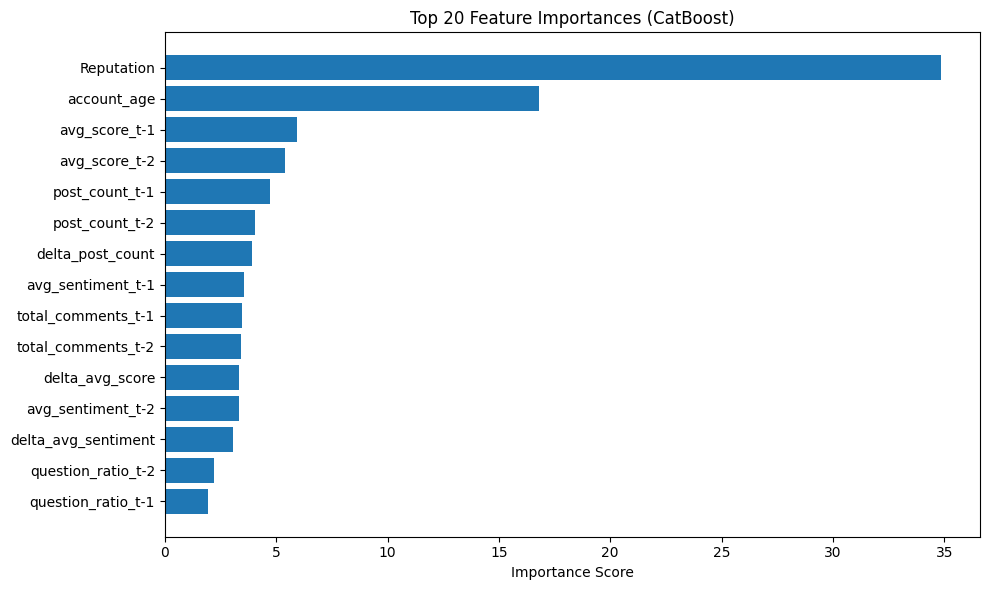

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 提取特征重要性
importances = cat_model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 打印前 10 个最重要的特征
print("\n=== Top 10 Important Features ===")
print(feature_importance_df.head(10))

# 可视化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20][::-1], feature_importance_df['Importance'][:20][::-1])
plt.title('Top 20 Feature Importances (CatBoost)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# 假设 y_test 是你的真实标签，y_proba 是预测为类别 1（活跃）的概率
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]

print("Threshold |  Precision  |  Recall     |  F1-score   |  Accuracy")
print("---------------------------------------------------------------")

for t in thresholds:
    y_pred_t = (y_proba > t).astype(int)
    p = precision_score(y_test, y_pred_t)
    r = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    acc = accuracy_score(y_test, y_pred_t)

    print(f"   {t:.2f}    |   {p:.4f}    |   {r:.4f}    |   {f1:.4f}   |   {acc:.4f}")

Threshold |  Precision  |  Recall     |  F1-score   |  Accuracy
---------------------------------------------------------------
   0.30    |   0.7152    |   0.9765    |   0.8257   |   0.7173
   0.35    |   0.7290    |   0.9616    |   0.8293   |   0.7286
   0.40    |   0.7437    |   0.9409    |   0.8308   |   0.7372
   0.45    |   0.7607    |   0.9116    |   0.8294   |   0.7428
   0.50    |   0.7811    |   0.8806    |   0.8279   |   0.7489


In [19]:
optimal_threshold = 0.40
y_pred_final = (y_proba > optimal_threshold).astype(int)

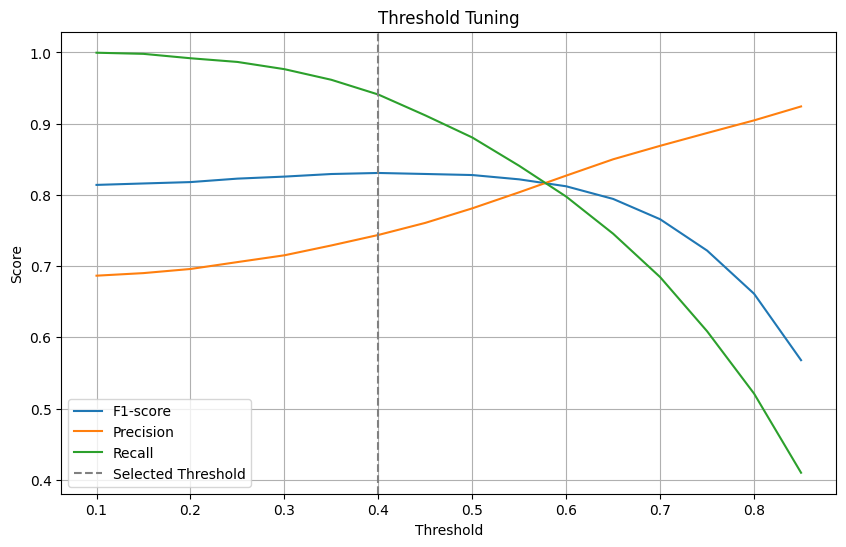

In [20]:

import matplotlib.pyplot as plt
import numpy as np

thresholds = np.arange(0.1, 0.9, 0.05)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    y_pred_t = (y_proba > t).astype(int)
    f1s.append(f1_score(y_test, y_pred_t))
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))

plt.figure(figsize=(10,6))
plt.plot(thresholds, f1s, label='F1-score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(0.40, color='gray', linestyle='--', label='Selected Threshold')
plt.title("Threshold Tuning")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [21]:
# 将测试集复制一份，添加预测结果列
X_test_sample = X_test.copy()
X_test_sample['true_label'] = y_test.values
X_test_sample['pred_label'] = y_pred
X_test_sample['pred_proba'] = y_proba

# 按预测概率排序，挑选几个示例查看
sample_to_view = X_test_sample.sort_values(by='pred_proba', ascending=False).head(5)

# 打印前 5 行预测结果
pd.set_option('display.max_columns', None)
print("\n=== 示例预测结果（Top 5 by prob）===\n")
print(sample_to_view[['pred_proba', 'pred_label', 'true_label'] + feature_cols].head())


=== 示例预测结果（Top 5 by prob）===

        pred_proba  pred_label  true_label  post_count_t-1  post_count_t-2  \
112254    0.991221           1           1           217.0            95.0   
115164    0.990629           1           1           226.0            29.0   
90545     0.990448           1           1            43.0            13.0   
127       0.989991           1           1             3.0             1.0   
10983     0.989644           1           1             2.0             1.0   

        delta_post_count  avg_score_t-1  avg_score_t-2  delta_avg_score  \
112254             122.0       0.373272       0.347368         0.025903   
115164             197.0       1.486726       0.310345         1.176381   
90545               30.0       3.093023       1.076923         2.016100   
127                  2.0       4.666667      90.000000       -85.333333   
10983                1.0       8.000000      22.000000       -14.000000   

        total_comments_t-1  total_comments_t-2  a

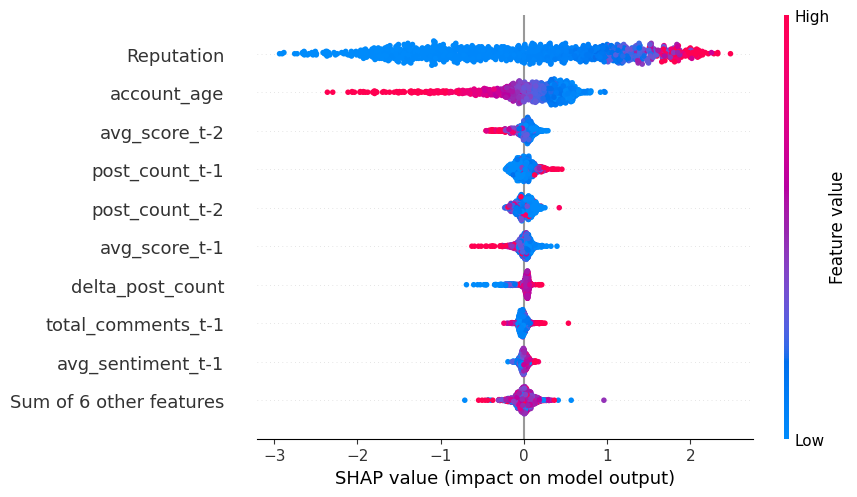

In [22]:
explainer = shap.Explainer(cat_model)
shap_values = explainer(X_test[:1000])

shap.plots.beeswarm(shap_values)